<a href="https://colab.research.google.com/github/Manar-Hamed/Arabic_Sign_Language/blob/main/Image_Text_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # Mounting Drive
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# Unziping the Images file
# !unzip data\ArASL_Database_54K_Final.zip -d data
# !tar -xf data\ArASL_Database_54K_Final.zip


In [3]:
# !pip install scikit-learn
# !pip install matplotlib
# !pip install opencv-python

In [4]:
# Importing required libraries

# from sklearn.preprocessing import LabelBinarizer
from keras.metrics import Precision, Recall, Accuracy
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras.utils import plot_model
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
import pandas as pd
# import pickle
# import random
import shutil
# import math
import cv2
import os


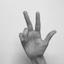

In [5]:
# Visualizing an Image
img = tf.keras.preprocessing.image.load_img(r'data\ArASL_Database_54K_Final\ArASL_Database_54K_Final\al\AL (1).JPG')
img

In [6]:
cv2.imread(r'data\ArASL_Database_54K_Final\ArASL_Database_54K_Final\al\AL (1).JPG').shape

(64, 64, 3)

In [7]:
img.size

(64, 64)

### Loading Images

In [8]:
# Loading images
data = tf.keras.utils.image_dataset_from_directory('data\ArASL_Database_54K_Final\ArASL_Database_54K_Final')

Found 54049 files belonging to 32 classes.


In [9]:
data_iterator = data.as_numpy_iterator()

In [10]:
batch = data_iterator.next()

In [11]:
batch[0].shape

(32, 256, 256, 3)

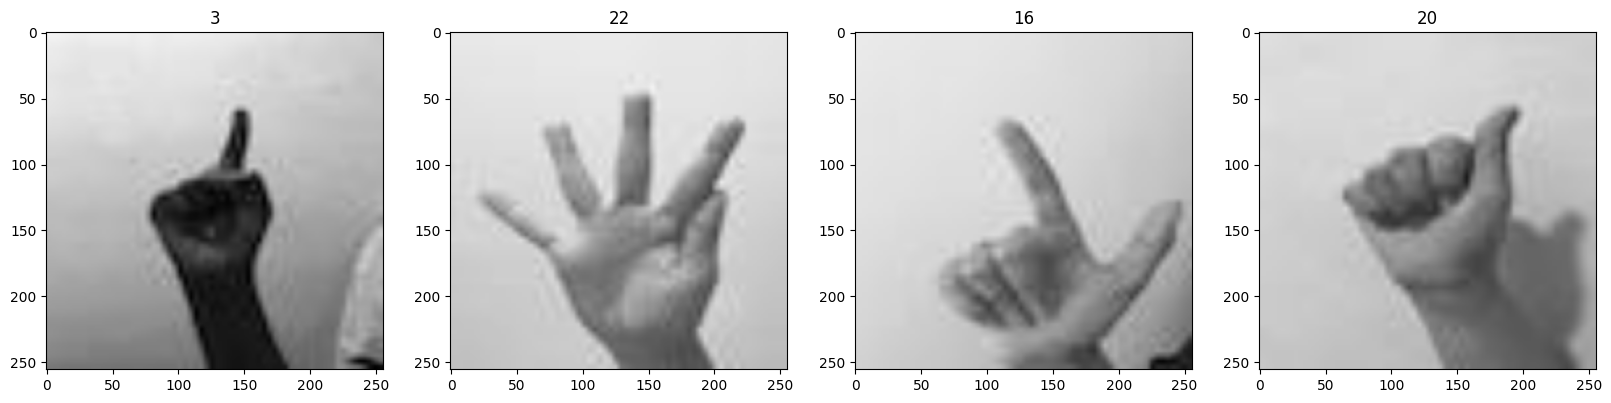

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

### Scaling Data

In [13]:
# Scale Data
data = data.map(lambda x,y: (x/255, y))

In [14]:
scaled_itertor = data.as_numpy_iterator()

In [15]:
batch = scaled_itertor.next()

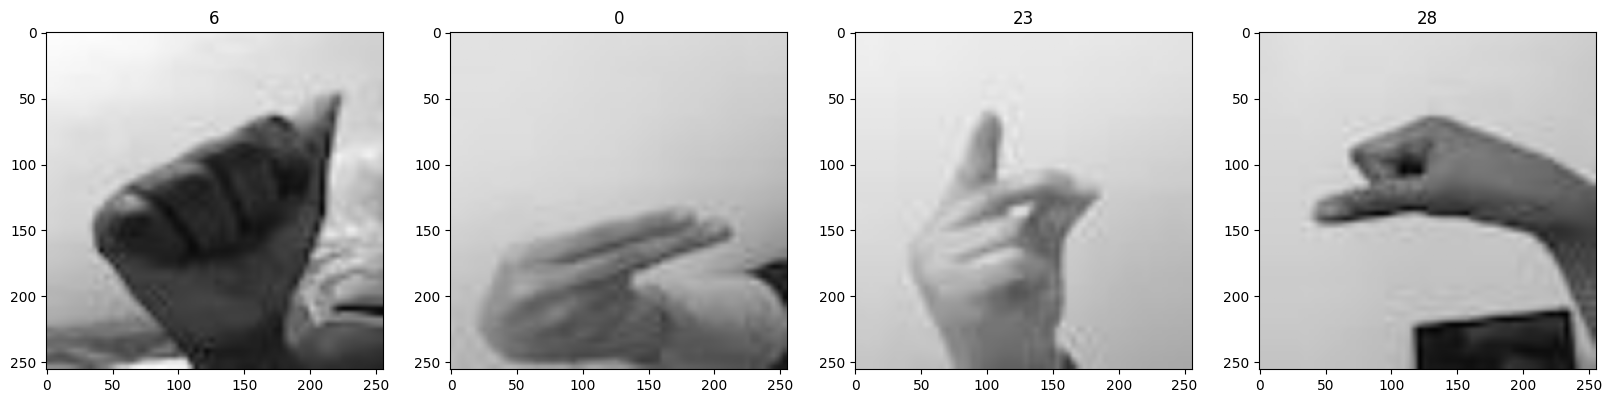

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

### Splitting Data

In [17]:
train_size = int(len(data) * 0.7)
test_size = int(len(data) * 0.2)
valid_size = int(len(data) * 0.1)

In [18]:
train =  data.take(train_size)
test = data.skip(train_size).take(test_size)
valid = data.skip(train_size+test_size).take(valid_size)

In [19]:
len(train)

1183

### Creating the CNN Model

In [20]:
# Defining the CNN

model = keras.models.Sequential()

model.add(keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(32, activation='softmax'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 16)       0

In [22]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
save_best_cb = keras.callbacks.ModelCheckpoint('models/best_model', save_best_only=True) # Saves the best model so far
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5) # Interupts training when there is no progress

#### Training

In [24]:
history = model.fit(train, epochs=20, validation_data=test, callbacks=[save_best_cb, early_stopping_cb])

Epoch 1/20
1183/1183 [==============================] - ETA: 0s - loss: 1.3568 - accuracy: 0.6276

INFO:tensorflow:Assets written to: models\best_model\assets


INFO:tensorflow:Assets written to: models\best_model\assets


1183/1183 [==============================] - 742s 627ms/step - loss: 1.3568 - accuracy: 0.6276 - val_loss: 0.4189 - val_accuracy: 0.8931
Epoch 2/20
1183/1183 [==============================] - ETA: 0s - loss: 0.2514 - accuracy: 0.9336

INFO:tensorflow:Assets written to: models\best_model\assets


INFO:tensorflow:Assets written to: models\best_model\assets


1183/1183 [==============================] - 695s 587ms/step - loss: 0.2514 - accuracy: 0.9336 - val_loss: 0.3475 - val_accuracy: 0.9129
Epoch 3/20
1183/1183 [==============================] - 738s 623ms/step - loss: 0.1175 - accuracy: 0.9672 - val_loss: 0.3704 - val_accuracy: 0.9247
Epoch 4/20
1183/1183 [==============================] - 671s 567ms/step - loss: 0.0664 - accuracy: 0.9808 - val_loss: 0.4645 - val_accuracy: 0.9214
Epoch 5/20
1183/1183 [==============================] - 684s 578ms/step - loss: 0.0548 - accuracy: 0.9857 - val_loss: 0.4049 - val_accuracy: 0.9323
Epoch 6/20
1183/1183 [==============================] - 667s 563ms/step - loss: 0.0350 - accuracy: 0.9914 - val_loss: 0.3943 - val_accuracy: 0.9391
Epoch 7/20
1183/1183 [==============================] - 672s 568ms/step - loss: 0.0287 - accuracy: 0.9924 - val_loss: 0.3922 - val_accuracy: 0.9340


In [25]:
history.history # Contains the training related information for each epoch

{'loss': [1.356799602508545,
  0.25137820839881897,
  0.1174679845571518,
  0.06636571884155273,
  0.054794345051050186,
  0.03498949110507965,
  0.02866065502166748],
 'accuracy': [0.6276151537895203,
  0.9336432814598083,
  0.9672442674636841,
  0.980848491191864,
  0.9856561422348022,
  0.9913619756698608,
  0.992418646812439],
 'val_loss': [0.41893401741981506,
  0.3475398123264313,
  0.3704197108745575,
  0.4644622802734375,
  0.40485575795173645,
  0.39429962635040283,
  0.3922460079193115],
 'val_accuracy': [0.8931213021278381,
  0.91290682554245,
  0.9247411489486694,
  0.9214127063751221,
  0.9323225021362305,
  0.939071774482727,
  0.9339866638183594]}

#### Performance Plotting

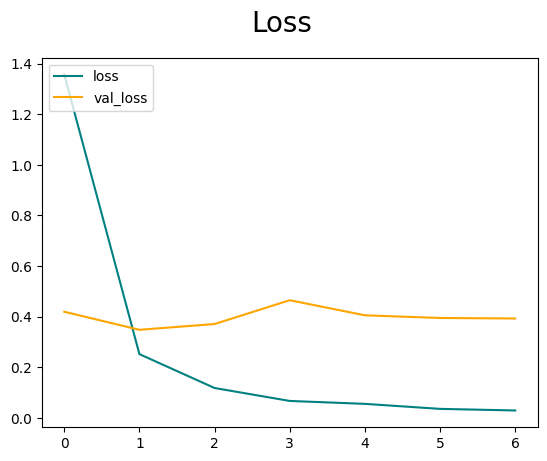

In [26]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

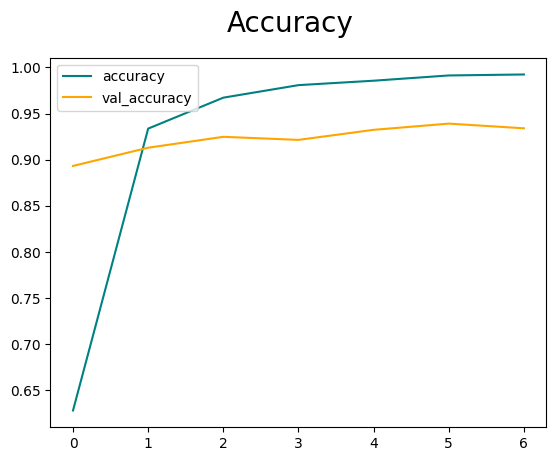

In [27]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

### Evaluate Performance

In [28]:
pre = Precision()
re = Recall()
acc = Accuracy()

In [29]:
for batch in valid.as_numpy_iterator():
  x, y = batch
  yhat = model.predict(x)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

1/1 [==============================] - 0s 301ms/step


ValueError: Shapes (32, 32) and (32,) are incompatible

In [ ]:
print(f'Precision: {pre.result().nupmy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

#### Testing

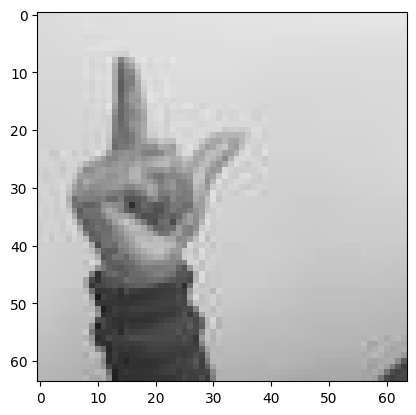

In [30]:
img = cv2.imread('data\Test\LAAM (10).JPG')
plt.imshow(img)
plt.show()

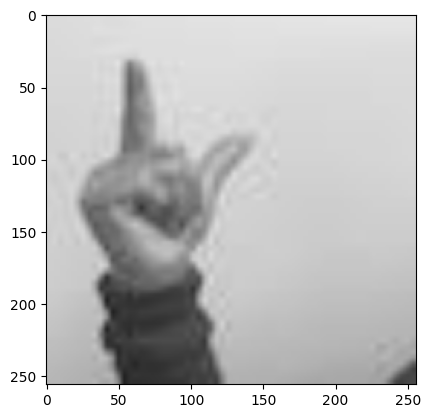

In [31]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [32]:
np.expand_dims(resize, 0)

array([[[[219.      , 219.      , 219.      ],
         [219.      , 219.      , 219.      ],
         [219.      , 219.      , 219.      ],
         ...,
         [230.      , 230.      , 230.      ],
         [230.      , 230.      , 230.      ],
         [230.      , 230.      , 230.      ]],

        [[219.      , 219.      , 219.      ],
         [219.      , 219.      , 219.      ],
         [219.      , 219.      , 219.      ],
         ...,
         [230.      , 230.      , 230.      ],
         [230.      , 230.      , 230.      ],
         [230.      , 230.      , 230.      ]],

        [[219.      , 219.      , 219.      ],
         [219.      , 219.      , 219.      ],
         [219.      , 219.      , 219.      ],
         ...,
         [229.875   , 229.875   , 229.875   ],
         [229.875   , 229.875   , 229.875   ],
         [229.875   , 229.875   , 229.875   ]],

        ...,

        [[183.125   , 183.125   , 183.125   ],
         [183.125   , 183.125   , 183.125   ]

In [33]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 79ms/step


In [54]:
yhat

array([[1.9767562e-08, 6.6725491e-04, 1.1522738e-07, 6.2364568e-05,
        2.0283363e-08, 1.0548746e-01, 7.9624612e-10, 2.4255771e-05,
        5.6554541e-07, 4.5890229e-06, 9.2435997e-09, 3.7553138e-05,
        8.7841824e-11, 2.8912270e-09, 8.1495875e-07, 3.8119889e-09,
        7.4495476e-01, 3.0380487e-04, 2.5433907e-04, 4.9009013e-06,
        1.0246659e-05, 5.2517977e-09, 5.7949312e-04, 2.1816001e-04,
        1.6534002e-02, 3.1558005e-04, 8.1899735e-08, 6.5266031e-06,
        1.3033175e-01, 9.5168498e-06, 6.1300978e-09, 1.9188819e-04]],
      dtype=float32)

In [58]:
maxValue = np.amax(yhat[0])
maxValue

0.74495476

In [65]:
result = np.where(yhat[0] == np.amax(yhat[0]))
phon_num = result[0][0]

### Save Model

In [62]:
# Saving the model
# model.save('models/ArSLText.h5')

In [63]:
# ArSL_model = load_model('models/ArSLText.h5')

In [72]:
# Loading Best Saved Model
ArSL_model = load_model('models/best_model')

### Converting Images to Letters

In [ ]:
# test -> Test Set

##### Making Arabic Letters Labels

In [ ]:
# encoded_labels = pd.DataFrame()

In [ ]:
#Classes Dictionary
# label = pd.read_csv('data\ArSL_Data_Labels.csv')

In [ ]:
# label.head(3)

,#,File_Name,Class
0,1,AIN (1).JPG,ain
1,2,AIN (10).JPG,ain
2,3,AIN (100).jpg,ain


In [ ]:
# encoded_labels['Phonteics'] = label['Class'].unique()

In [ ]:
# numbers  = [i for i in range(32)]

In [ ]:
# encoded_labels['Index'] = numbers

In [ ]:
# arab_list = list()

In [ ]:
# for eng_lab in  label['Class'].unique():
#   print('English Label: ', eng_lab)
#   arab_lab = input('Arabic Label: ')
#   arab_list.append(arab_lab)

In [ ]:
# encoded_labels['Arabic_Letters'] = arab_list

In [ ]:
# encoded_labels.head(3)

,Phonteics,Index,ِArabic_Letters
0,ain,0,ع
1,al,1,ال
2,aleff,2,أ


In [ ]:
# encoded_labels.to_csv('data/Arabic_Letters_Guide.csv', index=False)

#### .........................................

In [94]:
encoded_labels = pd.read_csv('data/Arabic_Letters_Guide.csv')
encoded_labels.head(3)

,Phonteics,Index,Arabic_Letters
0,ain,0,ع
1,al,1,ال
2,aleff,2,أ


In [95]:
# This shows that the model predicted the image correctly
letter = encoded_labels[encoded_labels['Index'] == phon_num]
arab_letter = letter['Arabic_Letters']
arab_letter

16    ل
Name: Arabic_Letters, dtype: object

In [ ]:
# Actual_Word = 'لغة'
# Predicted = ''

In [80]:
test_pics = data.random()

In [83]:
batch = test_pics.as_numpy_iterator().next()
# x, y = batch

In [84]:
predicted = ArSL_model.predict(x)

1/1 [==============================] - 0s 340ms/step


In [98]:
for i in range(predicted.shape[0]):
    pred_val = np.where(predicted[i] == np.amax(predicted[i]))
    letter = encoded_labels[encoded_labels['Index'] == pred_val[0][0]]
    arab_letter = letter['Arabic_Letters']
    print(arab_letter)

26    ذ
Name: Arabic_Letters, dtype: object
27    ة
Name: Arabic_Letters, dtype: object
0    ع
Name: Arabic_Letters, dtype: object
17    م
Name: Arabic_Letters, dtype: object
31    ز
Name: Arabic_Letters, dtype: object
22    ش
Name: Arabic_Letters, dtype: object
12    ج
Name: Arabic_Letters, dtype: object
7    ف
Name: Arabic_Letters, dtype: object
19    ر
Name: Arabic_Letters, dtype: object
23    ط
Name: Arabic_Letters, dtype: object
0    ع
Name: Arabic_Letters, dtype: object
0    ع
Name: Arabic_Letters, dtype: object
17    م
Name: Arabic_Letters, dtype: object
21    س
Name: Arabic_Letters, dtype: object
13    ك
Name: Arabic_Letters, dtype: object
3    ب
Name: Arabic_Letters, dtype: object
1    ال
Name: Arabic_Letters, dtype: object
17    م
Name: Arabic_Letters, dtype: object
2    أ
Name: Arabic_Letters, dtype: object
14    خ
Name: Arabic_Letters, dtype: object
9    غ
Name: Arabic_Letters, dtype: object
23    ط
Name: Arabic_Letters, dtype: object
2    أ
Name: Arabic_Letters, dtype: obj